In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Custom GTZAN Datasets

In this notebook we have collected all the datasets that we will use for our neural network

## Custom Transforms for our dataset

This is the trasform to normalize the data in the csv files

In [2]:
# This is a custom transform to normalize the features
class CustomNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, numpy_array):
        normalized_data = (numpy_array - self.mean) / self.std

        tensor = torch.from_numpy(normalized_data)
        return tensor



This is the trasform to change the labels from strings to one hot vectors

In [3]:
class LabelTransform:
    def __init__(self, label_set):
        # Map each of the first 10 letters of the alphabet to an index
        self.label_to_index = {label: index for index, label in enumerate(label_set)}

    def __call__(self, label):
        # Initialize a one-hot encoded tensor of size 10 (for 10 classes)
        one_hot = torch.zeros(10, dtype=torch.float)
        # Set the appropriate position to 1 based on the label index
        label_index = self.label_to_index[label]
        one_hot[label_index] = 1.0
        # return one_hot
        return self.label_to_index[label]

## Spectrogram Dataset

This is the dataset composed of spectogram images

In [4]:
class GTZANSpectogramDataset(Dataset):
    def __init__(self, features_file, img_dir, transform=None, target_transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load image data
        while True:
            try:
                img_name = self.generate_gtzan_full_img_name(self.features_frame.iloc[idx, 0], self.img_dir)
                image_rgba = Image.open(img_name)
                break
            except:
                # We skip the image that we can't open
                #print(f"Error opening image {img_name}")  # 'jazz.00054.png' is missing
                idx += 1
        image = image_rgba.convert("L")    # We convert the img to greyscale

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


    def generate_gtzan_full_img_name(self, original_img_name, img_dir):
        """ 
            The file name in the csv is 'reggae.00019.wav', 
            we neet to change it to '\\reggae\\reggae00019.png'
        """
        # We have to change the extension of the file
        img_file_name = original_img_name.replace('.wav', '.png')
        # To get the name of the folder we need to remove '.png' and the identifiers numbers (ex '.00000)'
        img_folder_name = img_file_name[:-10]    
        # Now we need to remove the '.' between 'reggae.00019'    
        img_file_name = img_file_name[:-10] + img_file_name[-9:]    
        # Now we can create the full path   
        img_name = os.path.join(img_dir, img_folder_name, img_file_name)

        return img_name

### Testing the dataset

In [5]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']

# Example usage of the transform
label_transform = LabelTransform(labels)


# This transform also normalizes
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.466],            
                         std=[0.459])
])


# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'
img_dir = 'Data\\images_original'

# Create the dataset
gtzan_dataset = GTZANSpectogramDataset(features_file=features_file, img_dir=img_dir, transform=transform_norm, target_transform=label_transform)

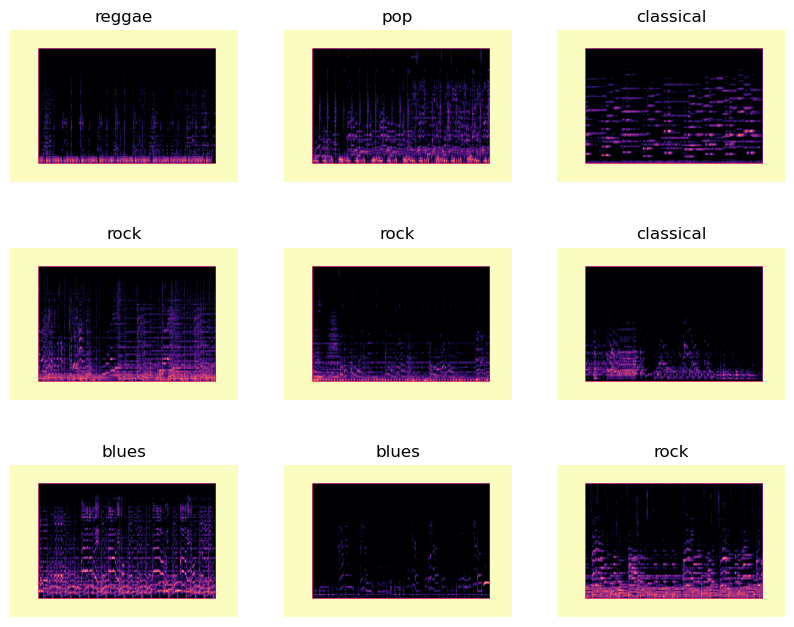

In [6]:
original_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']


# Testing the dataset
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(gtzan_dataset), size=(1,)).item()      # This line generates a random tensor with 1 element and the converts it to scalar
    # sample_idx = i
    img, label = gtzan_dataset[sample_idx]                                # 'training_data[sample_idx]' returns a tuple!

    figure.add_subplot(rows, cols, i)
    plt.title(original_labels[label])
    plt.axis("off")
    
    # The image is a [1, 288, 432] tensor, the first dimension is the batch size
    plt.imshow(img[0], cmap="magma")

plt.show()

### Testing the Dataloader

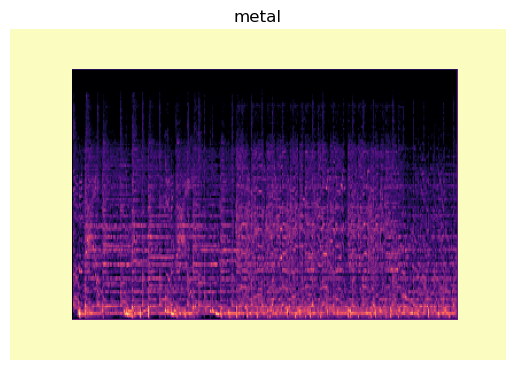

In [7]:
# Create a DataLoader
batch_size = 4
shuffle = True
num_workers = 0           # values over 0 means that it uses more cores to load the data

dataloader = DataLoader(gtzan_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)



# Example of using the dataloader in a training loop (we plot only the first image in the batch)
for i, data in enumerate(dataloader):
    images, labels = data
    img = images[0]
    plt.imshow(img[0], cmap="magma")
    plt.title(original_labels[labels[0]])
    plt.axis("off")
    break

### Computing the mean and std of spectogram data

This step is important because spectogram have a different distribution then normal images

In [8]:
def compute_mean_std(features_file, img_dir):
    # Basic Transform
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = GTZANSpectogramDataset(features_file=features_file, img_dir=img_dir, transform=transform)
    
    # Use a Batch size of 1
    dataloader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

    # Initial values
    mean = 0.0
    mean_sq = 0.0
    nb_samples = 0
    
    for i, data in enumerate(dataloader):
        images, labels = data
        
        # The image has this shape :(batch_size, RGB_channels, height, width)
        # print(images.shape)
        
        # Here we select the image from the batch
        image = images[0][0]
        # plt.imshow(image, cmap="magma")

        # We sum the mean and std of each channel
        mean += image.mean(dim=(0, 1))
        mean_sq += (image**2).mean(dim=(0, 1))          
        nb_samples += 1

    print(f"Number of samples: {nb_samples}")

    # Computing the mean and the mean of the squares
    mean /= nb_samples
    mean_sq /= nb_samples

    var = mean_sq - mean**2
    std = torch.sqrt(var)
    
    return mean, std


# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'
img_dir = 'Data\\images_original'

# Call this function with the path to your image directory
mean, std = compute_mean_std(features_file, img_dir)

print(f"Mean: {mean}")
print(f"Std: {std}")

Number of samples: 1000
Mean: 0.4665810465812683
Std: 0.4597361981868744


## 30s Dataset

This is the dataset of the features of the 30s songs

In [9]:
class GTZANFeaturesDataset(Dataset):
    def __init__(self, features_file, transform=None, target_transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load features
        features = self.features_frame.iloc[idx, 1:-1].to_numpy()
        #print(features.shape)
        features = features.astype('float')#.reshape(-1, 1)

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            features = self.transform(features)
        if self.target_transform:
            label = self.target_transform(label)

        # print(features.shape, label)
        return features.float(), label

### Testing the dataset

In [10]:
# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'

'CustomNormalize' is a custum transform to normalize the data in the dataset

In [11]:
# Here we compute the mean and the std of the features
data = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label'])
mean = data.mean().to_numpy()
std = data.std().to_numpy()

custom_norm = CustomNormalize(mean=mean, std=std)

'LabelTransform' is a custom trasform for the labels, that trasforms them from string to one hot data

In [12]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelTransform(labels)

# Example label
label = 'pop'  # Suppose 'c' is the label for a given sample

# Transform the label to one-hot encoded tensor
label_one_hot = label_transform(label)
print(f"Label: {label}, One-Hot Encoded: {label_one_hot}")

Label: pop, One-Hot Encoded: 7


Here we define our trasforms

In [13]:
# Define a transform to convert the images to tensors and normalize them
transform = label_transform

transform_norm = custom_norm

And here we create the dataset with the trasformations we want

In [14]:
# Create the dataset
gtzan_dataset = GTZANFeaturesDataset(features_file=features_file, transform=transform_norm, target_transform=label_transform)


# Here we generate the structure of the dataframe
columns = pd.read_csv(features_file).columns[2:-1]
test_output =  pd.DataFrame(columns = columns)


for i in range(5):
    # sample_idx = torch.randint(len(gtzan_dataset), size=(1,)).item() 
    sample_idx = i
    feature, label = gtzan_dataset[sample_idx] 
    feature_np = feature.numpy().reshape(-1, 1).T
    feature_df = pd.DataFrame(feature_np, columns=columns)
    test_output = pd.concat([test_output, feature_df], ignore_index=True)

test_output

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_14120\131503006.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_output = pd.concat([test_output, feature_df], ignore_index=True)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.349962,0.312431,-0.010684,-0.061825,-0.583293,-0.847887,-0.456174,-0.530776,-0.486229,-0.661603,...,-0.086353,-0.245991,0.500212,-0.779875,-0.236922,-0.642855,0.006720,-0.300447,0.603762,-0.512731
1,-0.462250,1.117013,-0.532586,-0.186727,-0.938046,-0.234077,-0.386658,0.795854,-0.648357,0.795425,...,-0.048078,-0.159095,0.711015,-0.069270,-0.054954,-0.453229,0.544533,-0.406883,0.423915,-0.538152
2,-0.184132,-0.137632,0.679638,-0.084051,-0.906431,-0.781303,-0.940192,-0.630600,-0.971106,-0.744033,...,0.284682,-0.595945,-0.827102,-0.447866,-0.600682,-0.329354,-0.295786,-0.527033,-0.296041,-0.874516
3,0.319479,0.990164,0.154732,0.906575,-1.580638,-0.711739,-1.227642,0.304413,-1.515631,-0.246407,...,-0.080208,-0.482601,0.142082,-0.371185,0.033410,-0.767208,0.455181,-0.779354,-0.602579,-0.844086
4,-0.858647,0.194066,-0.599865,-0.205806,-0.512286,-0.315021,-0.939300,-0.504210,-0.629792,-0.190422,...,-1.237996,0.750942,-0.327056,0.377431,-0.368191,-0.293549,-0.552740,-0.089338,-2.764625,-0.330122


### Testing the Dataloader

In [15]:
# Create a DataLoader
batch_size = 4
shuffle = True
num_workers = 0           # values over 0 means that it uses more cores to load the data

dataloader = DataLoader(gtzan_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Here we generate the structure of the dataframe
columns = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label']).columns
test_output =  pd.DataFrame(columns = columns)

# Example of using the dataloader in a training loop (we plot the whole batch)
for i, data in enumerate(dataloader):
    features, labels = data
    for i in range(len(features)):
        feature = features[i]
        feature_np = feature.numpy().reshape(-1, 1).T
        feature_df = pd.DataFrame(feature_np, columns=columns)
        test_output = pd.concat([test_output, feature_df], ignore_index=True)
    break

test_output

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_14120\2889132099.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_output = pd.concat([test_output, feature_df], ignore_index=True)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,2.164780,-3.461835,-0.190197,-0.802425,0.125521,-0.846321,-1.251668,-1.063253,-0.435331,-1.075041,...,0.862629,-0.708705,-0.093256,-0.947562,-0.463217,-1.176841,1.441454,-1.051539,0.330643,-1.026762
1,-1.066532,0.727324,-0.856066,-0.532057,-0.475572,0.218602,-0.219223,0.001806,-0.509569,0.110758,...,-0.791887,-0.378610,-0.238534,-0.042599,-0.055419,-0.811494,0.905676,-0.644449,-0.144042,-0.508440
2,-1.524540,0.340143,-0.291100,-0.443528,-0.265815,-0.713301,-0.027638,0.021307,-0.417406,-0.402945,...,-1.023136,-0.460895,0.677522,0.169239,-0.727710,1.894645,0.367243,2.149522,-1.135686,1.218578
3,-0.129645,-0.000697,-0.774647,-0.534174,0.851945,0.133644,1.138355,0.397447,0.945917,0.692391,...,-0.066715,-0.103982,0.946012,0.200838,-0.419657,-0.181402,-0.551879,-0.243394,-0.397622,0.486578
